In [226]:
import matplotlib.pyplot as plt
import numpy as np
import copy
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体
plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题


In [227]:


class BpNN(object):
    def __init__(self, layer_dims_, learning_rate=0.1, seed=16, initializer='xavier', optimizer='gd'):

        self.layer_dims_ = layer_dims_
        self.learning_rate = learning_rate
        self.seed = seed
        self.initializer = initializer
        self.optimizer = optimizer

    def fit(self, X_, y_, num_epochs=100):
        '''
        训练函数
        参数：
            X_:训练集特征
            y_:训练集标签
            num_epochs:迭代次数
        返回：
        '''
        m, n = X_.shape
        #print(X.shape)
        layer_dims_ = copy.deepcopy(self.layer_dims_)
        layer_dims_.insert(0, n)
        #print(layer_dims_)

        if y_.ndim == 1:
            y_ = y_.reshape(-1, 1)

        self.parameters_ = xavier_initializer(layer_dims_, self.seed)

        assert self.optimizer in ('gd', 'sgd')
        if self.optimizer == 'gd':
            parameters_, costs = self.optimizer_gd(X_, y_, self.parameters_, num_epochs, self.learning_rate)
        elif self.optimizer == 'sgd':
            parameters_, costs = self.optimizer_sgd(X_, y_, self.parameters_, num_epochs, self.learning_rate, self.seed)

        self.parameters_ = parameters_
        self.costs = costs

        return self

    def predict(self, X_):

        a_last, _ = self.forward_L_layer(X_, self.parameters_)
        if a_last.shape[1] == 1:
            predict_ = np.zeros(a_last.shape)
            predict_[a_last>=0.5] = 1
        else:
            predict_ = np.argmax(a_last, axis=1)
        return predict_

    def compute_cost(self, y_hat_, y_):
        if y_.ndim == 1:
            y_ = y_.reshape(-1, 1)
        if y_.shape[1] == 1:
            cost = cross_entry_sigmoid(y_hat_, y_)
        else:
            cost = cross_entry_softmax(y_hat_, y_)
        return cost

    def backward_one_layer(self, da_, cache_, activation_):
        '''
        反向传播1层
        参数：
            da_：当前层a梯度
            cache_：参数缓存
            activation_：激活函数
        返回：
            da_pre：上一层a的梯度
            dw:w梯度
            db:b梯度
        '''
        (a_pre_, w_, b_, z_) = cache_
        m = da_.shape[0]

        if activation_ == 'sigmoid':
            dz_ = sigmoid_backward(da_, z_)
        else:
            dz_ = relu_backward(da_, z_)

        dw = np.dot(dz_.T, a_pre_) / m                  #取样本均值
        db = np.sum(dz_, axis=0, keepdims=True) / m
        da_pre = np.dot(dz_, w_)

        return da_pre, dw, db

    def backward_L_layer(self, a_last, y_, caches):
        '''
        反向传播L层
        参数：
            a_last:
            y_:
            caches:参数缓存
        返回：
            grads:梯度矩阵
        '''

        grads = {}
        L = len(caches)

        if y_.ndim == 1:
            y_ = y_.reshape(-1, 1)

        if y_.shape[1] == 1:  # 目标值只有一列表示为二分类 
            da_last = -(y_ / a_last - (1 - y_) / (1 - a_last))          #链式求导得出，最后sigmoid层的da（即L对a的偏导）
            da_pre_L_1, dwL_, dbL_ = self.backward_one_layer(da_last, caches[L - 1], 'sigmoid')


        grads['da' + str(L)] = da_pre_L_1
        grads['dW' + str(L)] = dwL_
        grads['db' + str(L)] = dbL_

        for i in range(L - 1, 0, -1):
            da_pre_, dw, db = self.backward_one_layer(grads['da' + str(i + 1)], caches[i - 1], 'relu')

            grads['da' + str(i)] = da_pre_
            grads['dW' + str(i)] = dw
            grads['db' + str(i)] = db
        #print(grads)
        return grads

    def forward_one_layer(self, a_pre_, w_, b_, activation_):
        '''
        向前传播1层
        参数:
            a_pre_：上一层的函数值
            w_:权重矩阵
            b_：偏置项
            acivation:激活函数
        返回：
            a_:该层函数值
            cache_:缓存参数
        '''
        z_ = np.dot(a_pre_, w_.T) + b_
        assert activation_ in ('sigmoid', 'relu', 'softmax')

        if activation_ == 'sigmoid':
            a_ = sigmoid(z_)
        else:
            a_ = relu(z_)

        cache_ = (a_pre_, w_, b_, z_)  # 将向前传播过程中产生的数据保存下来，在向后传播过程计算梯度的时候要用上的。
        return a_, cache_

    def forward_L_layer(self, X_, parameters_):
        '''
        向前传播L层
        参数：
            X_：样本特征
            parameters：权重参数
        返回：
            a_last:最后一层函数值
            caches:所有缓存数据
        '''
        L_ = int(len(parameters_) / 2)                  #前进到最后一层
        caches = []
        a_ = X_                                         #第一层函数值就是样本数据
        for i in range(1, L_):
            w_ = parameters_['W' + str(i)]
            b_ = parameters_['b' + str(i)]
            a_pre_ = a_
            a_, cache_ = self.forward_one_layer(a_pre_, w_, b_, 'relu')
            caches.append(cache_)

        w_last = parameters_['W' + str(L_)]
        b_last = parameters_['b' + str(L_)]

        if w_last.shape[0] == 1:
            a_last, cache_ = self.forward_one_layer(a_, w_last, b_last, 'sigmoid')
        else:
            a_last, cache_ = self.forward_one_layer(a_, w_last, b_last, 'softmax')

        caches.append(cache_)
        return a_last, caches

    def optimizer_gd(self, X_, y_, parameters_, num_epochs, learning_rate):
        '''
        标准bp算法
        参数：
            X_:样本特征
            y_:样本标签
            parameters_:权重矩阵
            num_epochs:迭代次数
            learning_rate:学习率
        返回：
            parameters_:权重矩阵
            costs:代价值列表
        '''
        costs = []
        for i in range(num_epochs):
            a_last, caches = self.forward_L_layer(X_, parameters_)                          #使用所有样本计算参数和梯度
            grads = self.backward_L_layer(a_last, y_, caches)

            parameters_ = update_parameters_with_gd(parameters_, grads, learning_rate)
            cost = self.compute_cost(a_last, y_)

            costs.append(cost)

        return parameters_, costs

    def optimizer_sgd(self, X_, y_, parameters_, num_epochs, learning_rate, seed):
        '''
        sgd中，更新参数步骤和gd是一致的，只不过在计算梯度的时候是用一个样本而已。
        '''
        np.random.seed(seed)
        costs = []
        m_ = X_.shape[0]
        for _ in range(num_epochs):
            random_index = np.random.randint(0, m_)                                     #使用一个样本计算参数和梯度         
            a_last, caches = self.forward_L_layer(X_[[random_index], :], parameters_)
            grads = self.backward_L_layer(a_last, y_[[random_index], :], caches)

            parameters_ = update_parameters_with_sgd(parameters_, grads, learning_rate)

            a_last_cost, _ = self.forward_L_layer(X_, parameters_)

            cost = self.compute_cost(a_last_cost, y_)

            costs.append(cost)

        return parameters_, costs



其他函数

In [228]:
import numpy as np
from matplotlib import pyplot as plt


def cross_entry_softmax(y_hat_, y_):
    '''
    计算多分类时的交叉熵
    :param y_hat_:
    :param y_:
    :return:
    '''
    m = y_.shape[0]
    loss = -np.sum(y_ * np.log(y_hat_)) / m
    return loss

def xavier_initializer(layer_dims_, seed=16):
    np.random.seed(seed)

    parameters_ = {}
    num_L = len(layer_dims_)
    for l in range(num_L - 1):
        temp_w = np.random.randn(layer_dims_[l + 1], layer_dims_[l]) * np.sqrt(1 / layer_dims_[l])
        temp_b = np.zeros((1, layer_dims_[l + 1]))

        parameters_['W' + str(l + 1)] = temp_w
        parameters_['b' + str(l + 1)] = temp_b
    #print(parameters_)
    return parameters_


def cross_entry_sigmoid(y_hat_, y_):
    '''
    计算在二分类时的交叉熵
    :param y_hat_:  模型输出值
    :param y_:      样本真实标签值
    :return:
    '''

    m = y_.shape[0]
    loss = -(np.dot(y_.T, np.log(y_hat_)) + np.dot(1 - y_.T, np.log(1 - y_hat_))) / m

    return np.squeeze(loss)


def sigmoid(z):
    a = 1 / (1 + np.exp(-z))
    return a


def relu(z):
    a = np.maximum(0, z)
    return a


def softmax(z):
    z -= np.max(z)  # 防止过大，超出限制，导致计算结果为 nan
    z_exp = np.exp(z)
    softmax_z = z_exp / np.sum(z_exp, axis=1, keepdims=True)
    return softmax_z


def sigmoid_backward(da_, cache_z):
    a = 1 / (1 + np.exp(-cache_z))
    dz_ = da_ * a * (1 - a)
    return dz_


def softmax_backward(y_, cache_z):
    #
    a = softmax(cache_z)
    dz_ = a - y_
    assert dz_.shape == cache_z.shape
    return dz_


def relu_backward(da_, cache_z):
    dz = np.array(da_, copy=True)
    dz[cache_z <= 0] = 0
    assert (dz.shape == cache_z.shape)

    return dz


def update_parameters_with_gd(parameters_, grads, learning_rate):
    '''
    标准bp参数更新
    '''
    L_ = int(len(parameters_) / 2)

    for l in range(1, L_ + 1):
        parameters_['W' + str(l)] -= learning_rate * grads['dW' + str(l)]
        parameters_['b' + str(l)] -= learning_rate * grads['db' + str(l)]

    return parameters_


def update_parameters_with_sgd(parameters_, grads, learning_rate):
    '''
    累积bp参数更新
    '''
    L_ = int(len(parameters_) / 2)

    for l in range(1, L_ + 1):
        parameters_['W' + str(l)] -= learning_rate * grads['dW' + str(l)]
        parameters_['b' + str(l)] -= learning_rate * grads['db' + str(l)]

    return parameters_



准确率： 0.8095238095238095


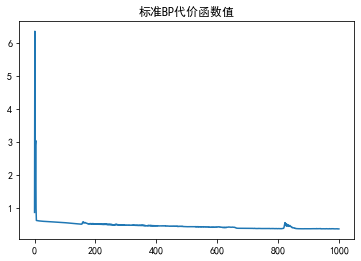

In [231]:
X=pd.read_csv("X.csv",index_col=0)
y=pd.read_csv("y.csv",index_col=0)
y=y["status"]
m,n=X.shape
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.8,random_state=1)
bp1 = BpNN([20,10,1], learning_rate=0.01, optimizer='gd')
bp1.fit(X_train.values, y_train.values, num_epochs=1000)
plt.plot(bp1.costs)
plt.title("标准BP代价函数值")
y_pre=bp1.predict(X_test)
y_pre=[b for a in y_pre for b in a ]
acc=0
for i in range(0,len(y_pre)):
    if y_pre[i]==y_test.iloc[i]:
        acc+=1
print('准确率：', acc/len(X_test))
